## Setup

In [1]:
# Import libraries

import sys
import os

import torch as pt
import gpytorch as gp
import numpy as np

import matplotlib.pyplot as plt

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import os
import sys
import itertools
from scipy.stats import pearsonr

# Set random seed and utility import (from your second script)
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from utility.utils import *
seed = 0 
set_random_seed(seed)

In [2]:
# Standard plotting parameters

fig_width = 3     # inches
fig_height = fig_width  # inches

dpi_val = 600  # graphics resolution

plt.rcParams['font.family'] = 'Arial'

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 6
tick_font_weight = 'roman'
label_font_size = 8
label_font_weight = 'roman'
title_font_size = 10
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'

hist_color = 'lightgrey'  # fill color of histogram bars
col_1 = 0
col_2 = 1
col_3 = 2
col_4 = 4
mean_color = 'c'  # cyan

x_tick_labels = [0.5, 1, 2, 4, 8, 11]
x_tick_values = np.log10(x_tick_labels)
y_tick_labels = [1, 0.1, 0.01, 0.001]
y_tick_values = [0, 1, 2, 3]
cb_tick_labels = [0, 0.25, 0.5, 0.75, 1]
cb_tick_values = cb_tick_labels

cb_pad = 0.05  # move colorbar xx units horizontally
cb_label_pad = -50  # move colorbar label xx units horizontally

num_spline_vals = 100  # number of interpolated points in spline curves

axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out'
}

color_map = 'gist_gray' # grayscale

p_title = 'CSF Phenotypes'
x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

save_dir  = './analysis/Figure01/'
file_stem = 'Figure01_Phenotypes'

data_dir = '../data/raw/'
data_file_name = 'csf_curves_exp1.json'
data_file_path = f'{data_dir}{data_file_name}'

In [3]:
# Load MATLAB Data and Transform it (from your second script)
data_dir = './'
data_file_name = 'four_D_thresh.mat'
file_path = f'{data_dir}{data_file_name}'
mat_data = scipy.io.loadmat(file_path)
cs_data = mat_data['cs']
log_cs_data = np.log10(cs_data)

# Append values to each slice (from your second script)
append_values = [0.5, 1, 2, 4, 8, 11]
structured_data_6x2 = []
for i in range(log_cs_data.shape[0]):
    for j in range(log_cs_data.shape[1]):
        for k in range(log_cs_data.shape[3]):
            log_slice = log_cs_data[i, j, :, k]
            paired_array = np.column_stack((log_slice, append_values))
            structured_data_6x2.append({'i': i, 'j': j, 'k': k, 'values': paired_array})

# Extract y-values (from your second script)
y_values = [data['values'][:, 0] for data in structured_data_6x2]
x_values_log10 = np.log10(append_values)

# Computing the pairwise Pearson correlation coefficients
correlation_coefficients = []
for combo in itertools.combinations(y_values, 2):
    corr, _ = pearsonr(combo[0], combo[1])
    correlation_coefficients.append(corr)

# Calculate the average correlation coefficient for each array
average_correlations = []
for i, y_array in enumerate(y_values):
    correlations = [pearsonr(y_array, other_array)[0] for j, other_array in enumerate(y_values) if i != j]
    average_correlations.append(np.mean(correlations))

# Divide these averages into 10 quantiles and select representative arrays
num_quantiles = 20
quantile_ranges = np.linspace(0, 100, num_quantiles + 1)
quantiles = np.percentile(average_correlations, quantile_ranges)

representative_indices = []
for q in range(len(quantiles)-1):
    quantile_range = (quantiles[q], quantiles[q+1])
    
    # Find indices in this quantile
    indices_in_quantile = [i for i, x in enumerate(average_correlations) if quantile_range[0] <= x < quantile_range[1]]

    # If the quantile has at least one element, select the one closest to the median
    if indices_in_quantile:
        median_of_quantile = np.median([average_correlations[i] for i in indices_in_quantile])
        closest_index = min(indices_in_quantile, key=lambda i: abs(average_correlations[i] - median_of_quantile))
        representative_indices.append(closest_index)

# Ensure that we have representatives for all quantiles
if len(representative_indices) < num_quantiles:
    missing_quantiles = num_quantiles - len(representative_indices)
    additional_indices = np.argsort(average_correlations)[-missing_quantiles:]
    representative_indices.extend(additional_indices)


# Define color maps
gray_colors = plt.cm.gray(np.linspace(0, 1, len(structured_data_6x2)))
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(representative_indices)))

<Figure size 640x480 with 0 Axes>

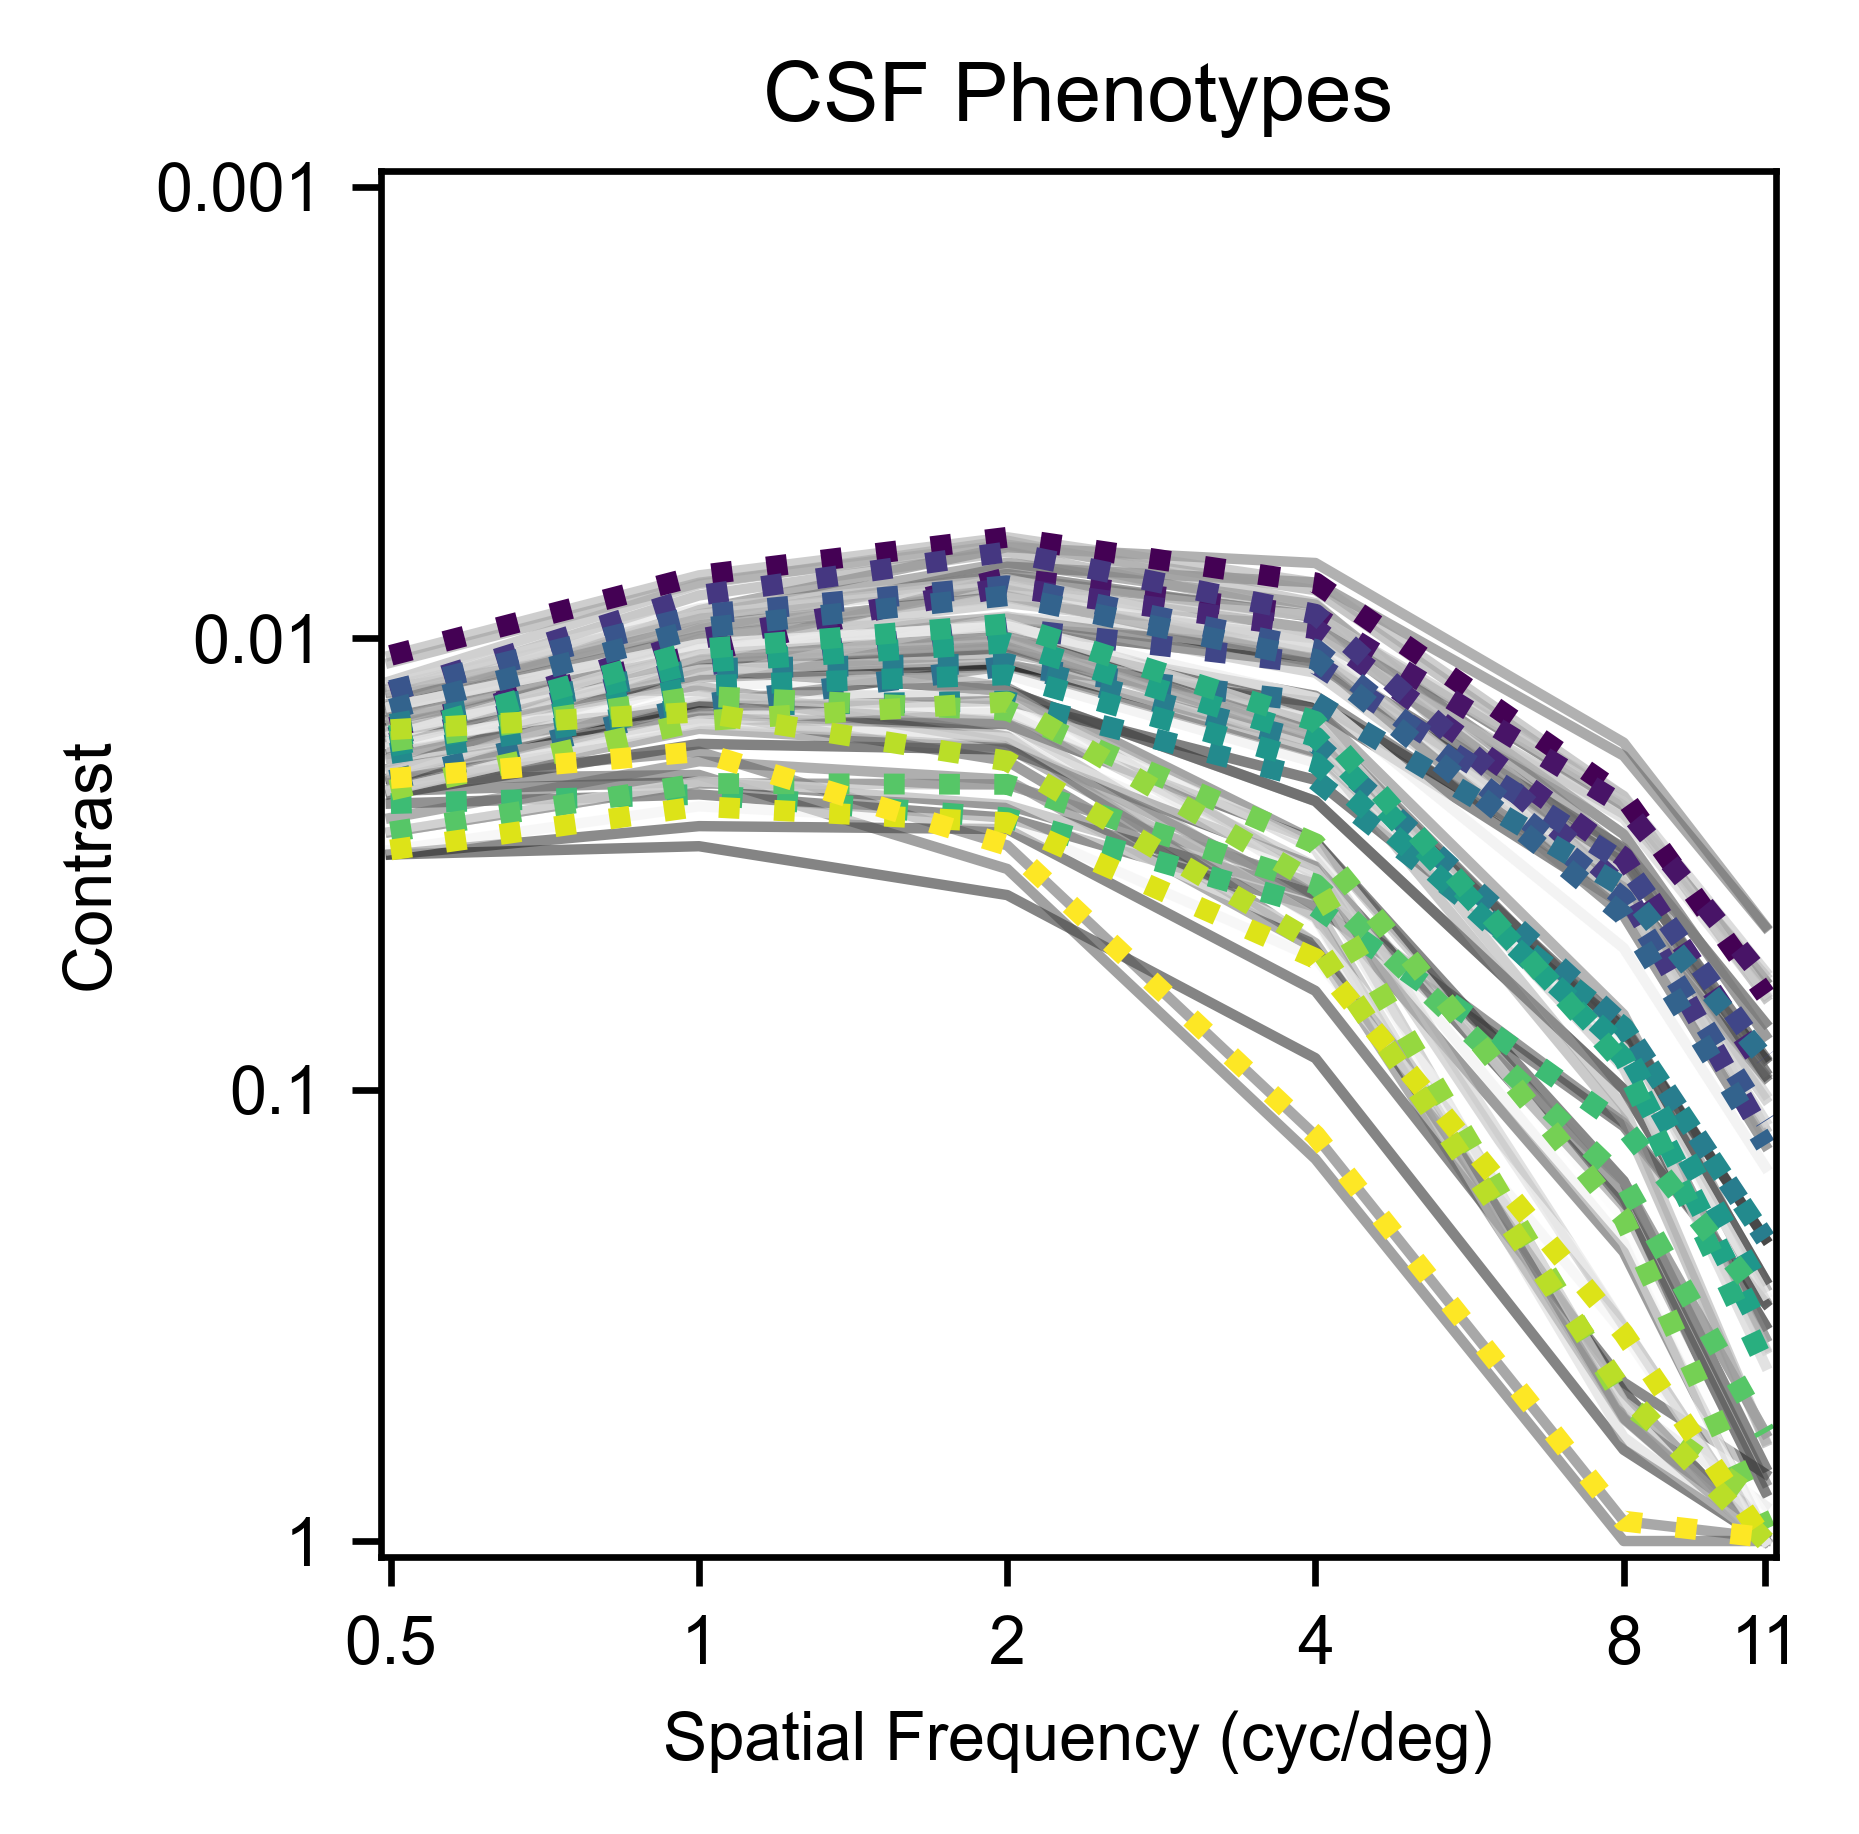

In [13]:
%matplotlib inline
plt.tight_layout()

fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi_val)

# Plot all 72 curves in gray
for idx, data in enumerate(structured_data_6x2):
    plt.plot(x_values_log10, data['values'][:, 0], alpha=0.5, color=gray_colors[idx], linewidth=1.25)

# Highlight representative curves in viridis color map
# first sort by geometric mean CS value
# the  "+ 0.01" ensures that 0 isn't multiplied and so none of them "tie" in mean when they really shouldn't
representative_indices.sort(key=lambda x: -1 * np.prod(structured_data_6x2[x]['values'][:, 0] + 0.01) ** (1/len(structured_data_6x2[x]['values'][:, 0])))
for rep_idx, idx in enumerate(representative_indices):
    data = structured_data_6x2[idx]
    i, j, k = data['i'], data['j'], data['k']
    label = f"Participant ID: {i}, Cue: {j}, Ecc: {k}"
    plt.plot(x_values_log10, data['values'][:, 0], color=viridis_colors[rep_idx], linewidth=2.5, linestyle='dotted', label=label)

# # plot the canonical CSF thresholds
# if plot_canon:
#     for rep_idx in enumerate(css):
#         label = phenotypes[i][0]
#         latent_x1 = np.linspace(left, right, num_spline_vals)
#         latent_x2 = cs(latent_x1)
#         plt.plot(latent_x1, latent_x2, label=label, linewidth=3)
    
plt.xticks(x_tick_values, x_tick_labels)
plt.yticks(y_tick_values, y_tick_labels)
xpadding = 0.01
ypadding = 0.035
plt.xlim(left=x_tick_values[0]-xpadding, right=x_tick_values[-1]+xpadding)
plt.ylim(bottom=y_tick_values[0]-ypadding, top=y_tick_values[-1]+ypadding)

# title and axis labels
plt.title(p_title, fontsize=title_font_size)
plt.xlabel(x_label, fontsize=label_font_size)
plt.ylabel(y_label, fontsize=label_font_size)
plt.tick_params(**axis_tick_params, labelsize=label_font_size)

if True:
    ensure_directory_exists(save_dir)
    plt.savefig(f'{save_dir}{file_stem}.png', bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f'{save_dir}{file_stem}.pdf', bbox_inches='tight', dpi=dpi_val)

if True:
    plt.show()
else:
    plt.clf()